In [1]:
%%capture
%run utils.ipynb
%run data.ipynb

import warnings
warnings.filterwarnings("ignore")

Most of the utility functions are implemented in 'utils.ipynb'. Data set is described in 'data.ipynb'.

# Hedging

The fundamental idea of hedging is to immunize the current position in derivative instruments against changes in the underlying asset. Hedging is set up by taking an opposite position in the underlying (i.e. long call, short asset). The size of the hedging positon is dependent on **the hedging strategy** used.

Various hedging strategies are considered below.

### Accuracy of hedging

Hedging strategy can be measured by the average accuracy of the hedge. Let $P_t$ be the derivative portfolio and $R_t$ the replicating (hedge) portfolio.

$$MSE=\frac{1}{N}\sum_{i=1}^N\big(dP_i-dR_i\big)^2$$

# Delta hedging (single option)

Delta hedging is set up as following

$$P_t=C_t-\Delta_t S_t$$

that is, portfolio $P_t$ consists being long call ($C_t:=$ price of an call at $t$) and short $\Delta$-units of the underlying ($S_t:=$ price of the underlying at $t$).

Now at time $t=0$, we form the portfolio

$$P_0=C_0-\Delta_0 S_0$$

Given our **rehedging frequency** k, the portfolio is rehedged. That is new $\Delta_{0+k}$ is calculated at time $t=k$ and corresponding portfolio $P_{0+k}$ is formed. Note: Variations in $C_t$ and $S_t$ are stochastic.

Delta is calculated by solving **implied volatility** from $C_t$ and using this to compute $\Delta_t$

### Data

Consider an at-the-money (ATM) option, maturing at 15.01.2010. As suggested in the assignment, let $t_0=$ 45 days to maturity.

In [2]:
isx15012010C = get_sheet('isx15012010C')
isx_m45 = isx15012010C[isx15012010C.shape[0]-45:].reset_index()
sp500_spot = isx_m45.iloc[0]['sp500_spot'] # S&P500 spot
sp500_spot

516.09

Since at $t_0$: $S_0=516.09$, call with $E=515$ is closest we can get to ATM. However, price series for this option is not complete (consists NaN values). Hence $E=520$ is chosen, which is in-the-money (ITM).

In [3]:
isx_m45_E520 = isx_m45[['days_to_mat',520,'sp500_spot','rf']]
isx_m45_E520 = isx_m45_E520
isx_m45_E520.head()

,days_to_mat,520,sp500_spot,rf
0,45,13.3,516.09,0.07
1,44,13.8,516.54,0.07
2,43,10.2,510.35,0.07
3,42,9.5,508.79,0.04
4,41,11.6,516.00,0.04


How did the underlying asset (S&P500 index) behave during the run time of the option? The asset was quite volatile during the period (up and down movement). This affects the hedging (when measured with MSE): the more frequent rebalancing leads to large changes in the replicating portfolio, and thus larger MSE.

Text(0, 0.5, 'Spot')

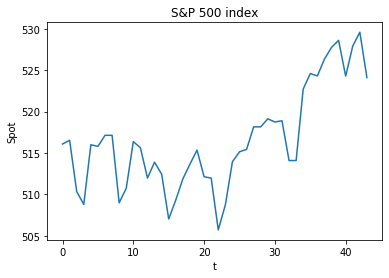

In [4]:
plt.plot(isx_m45_E520['sp500_spot'])
plt.title('S&P 500 index')
plt.xlabel('t')
plt.ylabel('Spot')

### Results: At-the-money option (isx15012010C, $E=520$)

Solve implied volatility for each time step $t$.

In [5]:
# Rowwise computations of implied vola and delta
def implied_vola_rows(E,row):  return solve_implied_vola(row[E],row['sp500_spot'],E,row['days_to_mat'],row['rf'])
def delta_rows(E,row): return delta_call(row['sp500_spot'],E,row['days_to_mat'],row['rf'],row['implied_vola='+str(E)])
def vega_rows(E,row): return vega_call(row['sp500_spot'],E,row['days_to_mat'],row['rf'],row['implied_vola='+str(E)])

In [6]:
isx_m45_E520['implied_vola=520'] = isx_m45_E520.apply(lambda row: implied_vola_rows(520,row), axis=1)

Solve delta for each time step $t$.

In [7]:
isx_m45_E520['delta=520'] = isx_m45_E520.apply(lambda row: delta_rows(520,row), axis=1)
isx_m45_E520_general = isx_m45_E520 # dataframe for general results

Set rows for corresponding rehedging frequency. Here rehedging frequency $k=2$.

In [9]:
isx_m45_E520['delta_freq'] = set_rehedge_freq(2,isx_m45_E520['delta=520']) # rehedging frequency = 2
isx_m45_E520['hedge_pos'] = isx_m45_E520.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
isx_m45_E520['change_P'] = isx_m45_E520[520].diff()
isx_m45_E520['change_R'] = isx_m45_E520['hedge_pos'].diff()
isx_m45_E520['MSE'] = isx_m45_E520.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)

In [10]:
isx_m45_E520.head()

,days_to_mat,520,sp500_spot,rf,implied_vola=520,delta=520,vega=520,delta_freq,hedge_pos,change_P,change_R,MSE
0,45,13.3,516.09,0.07,0.180213,0.519439,72.207010,0.519439,268.077297,NaN,NaN,NaN
1,44,13.8,516.54,0.07,0.186651,0.523761,71.420468,0.519439,268.311045,0.5,0.233748,0.070890
2,43,10.2,510.35,0.07,0.180940,0.445206,69.221906,0.445206,227.210627,-3.6,-41.100417,1406.281292
3,42,9.5,508.79,0.04,0.193750,0.409551,67.076318,0.445206,226.516107,-0.7,-0.694521,0.000030
4,41,11.6,516.00,0.04,0.179705,0.490627,68.973996,0.490627,253.163736,2.1,26.647630,602.586117


Plot delta timeseries to see if it is **stable** and seem reasonable.

Text(0.5, 0, 'Time')

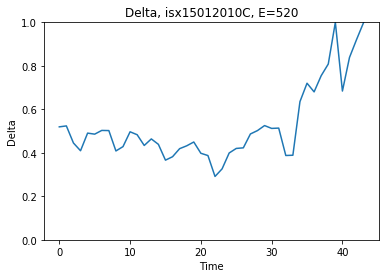

In [11]:
plt.plot(isx_m45_E520['delta=520'])
plt.ylim(0, 1)
plt.title('Delta, isx15012010C, E=520')
plt.ylabel("Delta")
plt.xlabel("Time")

As the option is chosen ITM, the delta is in the 0.5 region for most of the time (as expected). As the price of the underlying increases and finally is way above the strike, delta reaches 1. (Interpreting the delta as the probability of the option expiring in the money).

In [12]:
isx_m45_E520['MSE'].sum()/isx_m45_E520['MSE'].count() # Average hedging (square) error

1485.8262522898835

Delta hedging isx15012010C, $E=520$ with rehedging frequency $k=2$: $MSE=1485.83$

This seems quite high so lets check the computation data more carefully. (Last columns contains the hedging error for each time step).

In [13]:
isx_m45_E520[['days_to_mat',520,'sp500_spot','delta_freq','hedge_pos','change_P','change_R','MSE']]

,days_to_mat,520,sp500_spot,delta_freq,hedge_pos,change_P,change_R,MSE
0,45,13.30,516.09,0.519439,268.077297,NaN,NaN,NaN
1,44,13.80,516.54,0.519439,268.311045,0.50,0.233748,0.070890
2,43,10.20,510.35,0.445206,227.210627,-3.60,-41.100417,1406.281292
3,42,9.50,508.79,0.445206,226.516107,-0.70,-0.694521,0.000030
4,41,11.60,516.00,0.490627,253.163736,2.10,26.647630,602.586117
5,40,11.00,515.80,0.490627,253.065611,-0.60,-0.098125,0.251878
6,39,11.65,517.14,0.503026,260.135056,0.65,7.069445,41.209280
7,38,11.65,517.14,0.503026,260.135056,0.00,0.000000,0.000000
8,37,9.00,508.98,0.408595,207.966620,-2.65,-52.168437,2452.075559
9,36,9.60,510.74,0.408595,208.685747,0.60,0.719127,0.014191


It seems like that delta becomes more volatile towards the end of lifetime of the option (in case ITM). In above the single largest hedging errors are from 11 and 3 days to maturity (16880.8 and 15759.0 respectively).

It seems like everything is computed correctly to this stage.

With different rehedging frequencies:

$k=3$

In [14]:
isx_m45_E520['delta_freq'] = set_rehedge_freq(3,isx_m45_E520['delta=520'])

In [15]:
isx_m45_E520['hedge_pos'] = isx_m45_E520.apply(lambda row: row['sp500_spot']*row['delta_freq'],axis=1)
isx_m45_E520['change_P'] = isx_m45_E520[520].diff()
isx_m45_E520['change_R'] = isx_m45_E520['hedge_pos'].diff()
isx_m45_E520['MSE'] = isx_m45_E520.apply(lambda row: (row['change_P']-row['change_R'])**2,axis=1)
isx_m45_E520['MSE'].sum()/isx_m45_E520['MSE'].count()

1625.729144408308

Delta hedging isx15012010C, $E=520$ with rehedging frequency $k=3$: $MSE=1625.72$

To generalize the results, lets plot $MSE$ as a function of rehedging frequency $k$ for isx15012010C, $E=520$.

Text(0.5, 0, 'Rehedging frequency')

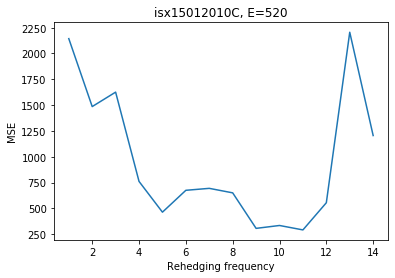

In [16]:
plt.plot(range(1,15),[MSE_delta_for_freq_strike(520,x,isx_m45_E520_general) for x in range(1,15)])
plt.title("isx15012010C, E=520")
plt.ylabel("MSE")
plt.xlabel("Rehedging frequency")

The result is unexpected: hedging accuracy measured by MSE is better with longer rehedging frequencies.

### Results: In-the-money option (isx15012010C, $E=500$)

In [17]:
isx_m45_E500 = isx_m45[['days_to_mat',500,'sp500_spot','rf']]
isx_m45_E500.head()

,days_to_mat,500,sp500_spot,rf
0,45,25.80,516.09,0.07
1,44,26.25,516.54,0.07
2,43,21.50,510.35,0.07
3,42,20.25,508.79,0.04
4,41,24.00,516.00,0.04


In [18]:
isx_m45_E500['implied_vola=500'] = isx_m45_E500.apply(lambda row: implied_vola_rows(500,row), axis=1)
isx_m45_E500['delta=500'] = isx_m45_E500.apply(lambda row: delta_rows(500,row), axis=1)
isx_m45_E500.head()

,days_to_mat,500,sp500_spot,rf,implied_vola=500,delta=500
0,45,25.80,516.09,0.07,0.185945,0.742136
1,44,26.25,516.54,0.07,0.191233,0.742298
2,43,21.50,510.35,0.07,0.188957,0.682781
3,42,20.25,508.79,0.04,0.205838,0.636988
4,41,24.00,516.00,0.04,0.190034,0.724729


Text(0.5, 0, 'Time')

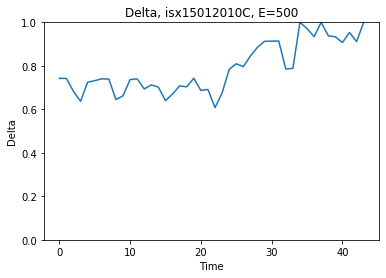

In [19]:
plt.plot(isx_m45_E500['delta=500'])
plt.ylim(0, 1)
plt.title('Delta, isx15012010C, E=500')
plt.ylabel("Delta")
plt.xlabel("Time")

From the above delta plot we can see that computation of delta (through implied volatility) has not been **stable**.

Text(0.5, 0, 'Rehedging frequency')

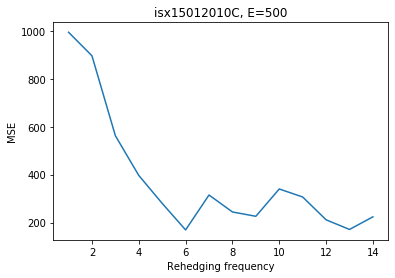

In [20]:
plt.plot(range(1,15),[MSE_delta_for_freq_strike(500,x,isx_m45_E500) for x in range(1,15)])
plt.title("isx15012010C, E=500")
plt.ylabel("MSE")
plt.xlabel("Rehedging frequency")

### Results: Out-the-money option (isx15012010C, $E=540$)

In [21]:
isx_m45_E540 = isx_m45[['days_to_mat',540,'sp500_spot','rf']]
isx_m45_E540.head()

,days_to_mat,540,sp500_spot,rf
0,45,5.65,516.09,0.07
1,44,5.65,516.54,0.07
2,43,4.00,510.35,0.07
3,42,3.20,508.79,0.04
4,41,4.10,516.00,0.04


In [22]:
isx_m45_E540['implied_vola=540'] = isx_m45_E540.apply(lambda row: implied_vola_rows(540,row), axis=1)
isx_m45_E540['delta=540'] = isx_m45_E540.apply(lambda row: delta_rows(540,row), axis=1)
isx_m45_E540.head()

,days_to_mat,540,sp500_spot,rf,implied_vola=540,delta=540
0,45,5.65,516.09,0.07,1.778030e-01,0.289119
1,44,5.65,516.54,0.07,1.781358e-01,0.290890
2,43,4.00,510.35,0.07,1.796929e-01,0.226303
3,42,3.20,508.79,0.04,-2.572883e+12,0.000000
4,41,4.10,516.00,0.04,1.690803e-01,0.243642


Text(0.5, 0, 'Time')

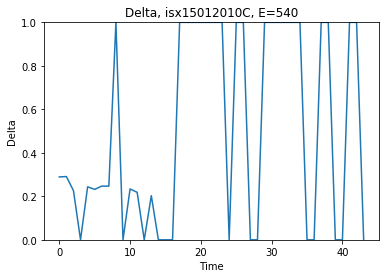

In [23]:
plt.plot(isx_m45_E540['delta=540'])
plt.ylim(0, 1)
plt.title('Delta, isx15012010C, E=540')
plt.ylabel("Delta")
plt.xlabel("Time")

Computation of delta is not **stable**.

From this we can deduce that the the computation is stable for strikes approximately in range $[500,535]$

### Results (isx15012010C, other strike prices)

Choosing options with strikes prices such that we can establish some stability in the computations.

In [24]:
strikes = isx_m45.columns.values[2:49]
strikes = strikes[32:-8]
strikes

array([500, 505, 510, 515, 520, 525, 530], dtype=object)

Implied volatility and delta for all of the options in the dataframe (**computation heavy**). Solves $45\cdot47=2115$ times the implied volatility problem by Newton's iteration.

In [25]:
dataf = volas_and_deltas_df(isx_m45,strikes)

>> Implied volas and deltas computed.
>> Time taken 8.772924423217773 s


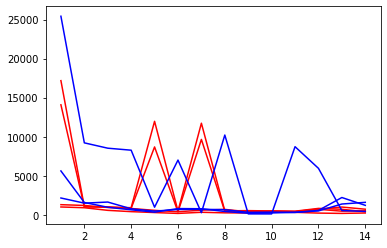

In [26]:
for E in strikes:
    MSEs = [MSE_delta_for_freq_strike(E,x,dataf) for x in range(1,15)]
    if E < sp500_spot:
        # OTM: red
        plt.plot(range(1,15),MSEs,'r-')
    else:
        # ITM: blue
        plt.plot(range(1,15),MSEs,'b-')

### Sanity checks with delta curves

Text(0.5, 0, 'Strike')

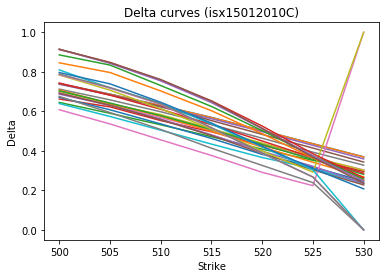

In [27]:
deltas = ['days_to_mat'] + ['delta='+str(x) for x in strikes]
delta_df = dataf[deltas].iloc[5:-1,]
for d in range(1,len(delta_df)-10):
    plt.plot(strikes,delta_df.iloc[d,1:].values)
plt.title("Delta curves (isx15012010C)")
plt.ylabel("Delta")
plt.xlabel("Strike")

In above figure delta curve is plotted for each day. The curves become more steeper as the maturity approaches. Also the general shape of the curves is what we would expect for call delta: for in-the-money options, probability for the option to mature in the money high. For out-of-the-money options, this probability is low.

Note that the above figure also highlights some computational **instability**.

In [28]:
delta_df

,days_to_mat,delta=500,delta=505,delta=510,delta=515,delta=520,delta=525,delta=530
5,40,0.731711,0.676757,0.618443,0.551972,0.485888,0.420860,0.349956
6,39,0.740433,0.687157,0.629552,0.569169,0.503026,0.436180,0.369371
7,38,0.739149,0.686035,0.628579,0.568309,0.502320,0.435601,0.368905
8,37,0.645015,0.589907,0.531649,0.471509,0.408595,0.352179,0.296938
9,36,0.662156,0.622493,0.553228,0.496453,0.428537,0.364495,0.296604
10,35,0.736776,0.683666,0.621719,0.562602,0.496714,0.427757,0.359172
11,34,0.740289,0.682454,0.624965,0.553063,0.483258,0.414047,0.343336
12,33,0.693783,0.632942,0.568426,0.501840,0.433861,0.365617,0.303380
13,32,0.712392,0.657892,0.597617,0.532985,0.463956,0.393221,0.327623
14,31,0.702153,0.637409,0.583148,0.511683,0.439019,0.367802,0.301918


### Results (isx19022010C)

Testing options with maturity 15.01.2010.

In [29]:
isx19022010C = get_sheet('isx19022010C')
isx_1501_selected = isx19022010C[['days_to_mat',460,480,500,520,'sp500_spot','rf']]
isx_1501_selected.head()

,days_to_mat,460,480,500,520,sp500_spot,rf
0,90,53.45,38.25,25.25,15.05,506.75,0.07
1,89,53.30,38.25,25.20,14.90,504.52,0.07
2,88,49.60,34.85,22.30,12.70,500.24,0.07
3,87,53.10,37.80,24.75,14.40,504.84,0.07
4,86,49.40,34.70,22.25,12.70,500.00,0.07


Underlying during the period

Text(0, 0.5, 'Spot')

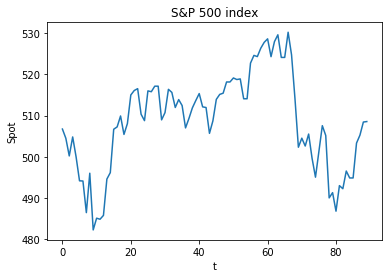

In [30]:
plt.plot(isx_1501_selected['sp500_spot'])
plt.title('S&P 500 index')
plt.xlabel('t')
plt.ylabel('Spot')

In [31]:
strikes_s = [460,480,500,520]
dafa_f_s = volas_and_deltas_df(isx_1501_selected,strikes_s)

>> Implied volas and deltas computed.
>> Time taken 34.93800377845764 s


In [32]:
dafa_f_s.head()

,days_to_mat,460,480,500,520,sp500_spot,rf,implied_vola=460,delta=460,implied_vola=480,delta=480,implied_vola=500,delta=500,implied_vola=520,delta=520
0,90,53.45,38.25,25.25,15.05,506.75,0.07,1.983775e+12,1.000000,0.150228,0.840294,0.166726,0.659776,0.170040,0.476456
1,89,53.30,38.25,25.20,14.90,504.52,0.07,1.469150e-01,0.938822,0.179259,0.788123,0.183212,0.630574,0.180412,0.458943
2,88,49.60,34.85,22.30,12.70,500.24,0.07,1.574312e-01,0.910177,0.179990,0.758811,0.181887,0.594446,0.178532,0.418558
3,87,53.10,37.80,24.75,14.40,504.84,0.07,1.358920e-01,0.954165,0.173280,0.798405,0.179493,0.634632,0.176710,0.457626
4,86,49.40,34.70,22.25,12.70,500.00,0.07,1.635057e-01,0.902871,0.184215,0.753545,0.186082,0.590084,0.182446,0.415915


Are the deltas **stable**?

In [33]:
deltas_s = ['delta='+str(x) for x in strikes_s]
delta_df_s = dafa_f_s[deltas_s]

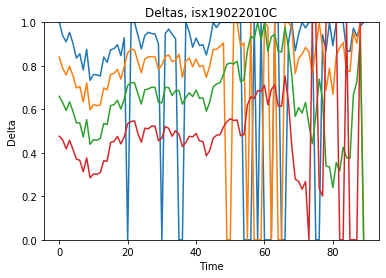

In [34]:
plt.ylim(0, 1)
plt.title('Deltas, isx19022010C')
plt.ylabel("Delta")
plt.xlabel("Time")

for E in strikes_s:
    plt.plot(delta_df_s['delta='+str(E)])

Nope.

Text(0.5, 0, 'Time')

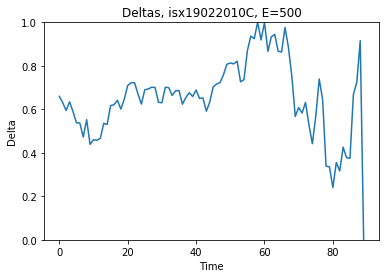

In [35]:
plt.plot(delta_df_s['delta=500'])
plt.ylim(0, 1)
plt.title('Deltas, isx19022010C, E=500')
plt.ylabel("Delta")
plt.xlabel("Time")

Text(0.5, 0, 'Rehedging frequency')

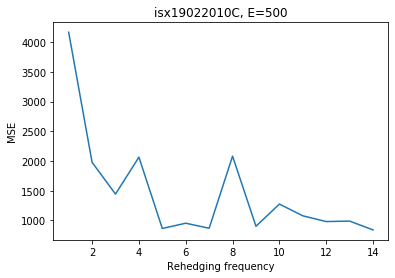

In [36]:
plt.plot(range(1,15),[MSE_delta_for_freq_strike(500,x,dafa_f_s) for x in range(1,15)])
plt.title("isx19022010C, E=500")
plt.ylabel("MSE")
plt.xlabel("Rehedging frequency")